In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

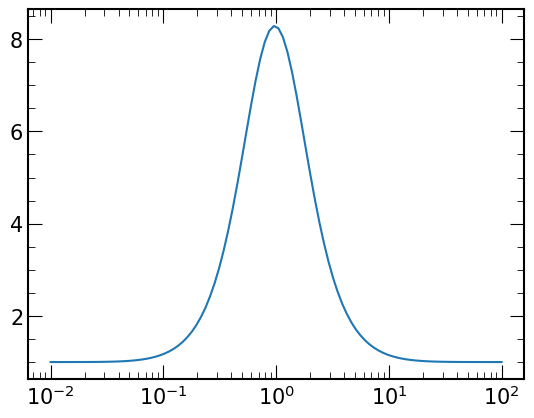

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-f56d36eb94c6>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
8.115867614746094
2.5 0.1
finished until t = 0.0 0.9366273880004883


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.428143739700317
finished until t = 1.0 12.459169149398804
finished until t = 1.5 21.836021423339844
finished until t = 2.0 33.40969228744507
finished until t = 2.5 46.37306761741638
finished until t = 3.0 61.28730225563049
finished until t = 3.5 77.75359582901001
finished until t = 4.0 95.76359844207764
finished until t = 4.5 115.76966786384583
finished until t = 5.0 136.9443643093109
finished until t = 5.5 160.3261218070984
finished until t = 6.0 184.9141137599945
finished until t = 6.5 210.89002633094788
finished until t = 7.0 237.8366892337799
finished until t = 7.5 266.98343324661255
finished until t = 8.0 297.27725100517273
finished until t = 8.5 329.20763635635376
finished until t = 9.0 362.4631679058075
finished until t = 9.5 397.30270624160767
finished until t = 10.0 435.1829032897949


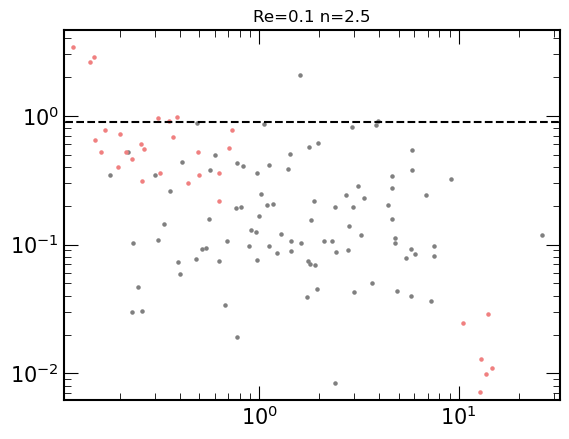

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.012519598007202
2.5 0.6
finished until t = 0.0 0.4999048709869385
finished until t = 0.5 4.015122413635254
finished until t = 1.0 10.887904167175293
finished until t = 1.5 22.555424451828003
finished until t = 2.0 36.57678723335266
finished until t = 2.5 54.28489661216736
finished until t = 3.0 75.86032438278198
finished until t = 3.5 102.25253748893738
finished until t = 4.0 135.03876328468323
finished until t = 4.5 172.4133768081665
finished until t = 5.0 213.28642177581787
finished until t = 5.5 261.50008177757263
finished until t = 6.0 315.9094774723053
finished until t = 6.5 374.34951424598694
finished until t = 7.0 436.4454834461212
finished until t = 7.5 499.4127643108368
finished until t = 8.0 567.7078824043274
finished until t = 8.5 641.8959550857544
finished until t = 9.0 719.0338900089264
finished until t = 9.5 800.3087844848633
finished until t = 10.0 886.051917552948


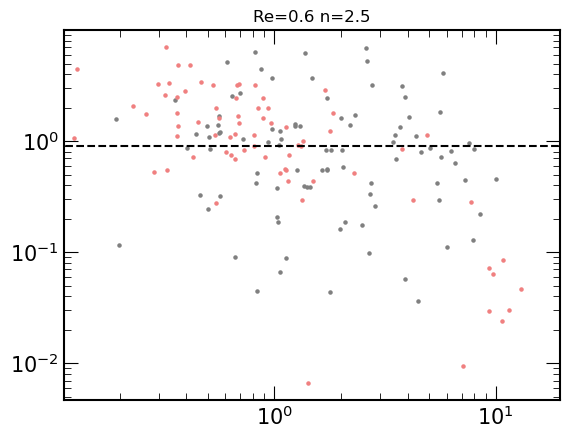

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.582643508911133
2.5 1.1
finished until t = 0.0 0.6621153354644775
finished until t = 0.5 4.895167827606201
finished until t = 1.0 13.28131103515625
finished until t = 1.5 26.377636194229126
finished until t = 2.0 43.199100971221924
finished until t = 2.5 64.68877053260803
finished until t = 3.0 92.09519863128662
finished until t = 3.5 123.80014276504517
finished until t = 4.0 159.99376440048218
finished until t = 4.5 200.67001461982727
finished until t = 5.0 245.85449767112732
finished until t = 5.5 296.0686936378479
finished until t = 6.0 350.35223293304443
finished until t = 6.5 408.89802527427673
finished until t = 7.0 472.0662968158722
finished until t = 7.5 539.467077255249
finished until t = 8.0 611.7683084011078
finished until t = 8.5 688.6032545566559
finished until t = 9.0 769.5621790885925
finished until t = 9.5 854.6614301204681
finished until t = 10.0 944.0049481391907


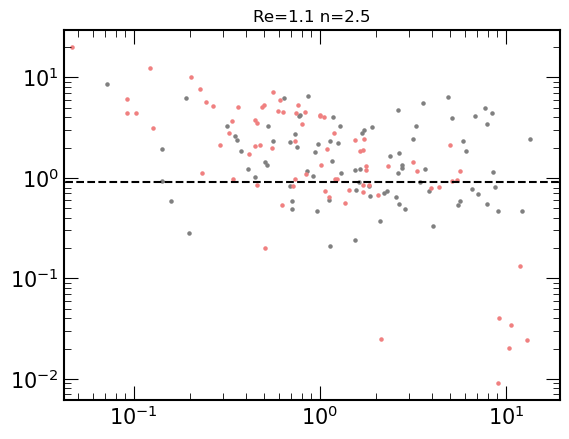

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.191160917282104
2.5 1.6
finished until t = 0.0 0.7936866283416748
finished until t = 0.5 6.212525844573975
finished until t = 1.0 16.184650182724
finished until t = 1.5 30.725427389144897
finished until t = 2.0 50.424681425094604
finished until t = 2.5 74.87649273872375
finished until t = 3.0 104.69541430473328
finished until t = 3.5 138.87206768989563
finished until t = 4.0 178.3978238105774
finished until t = 4.5 222.29669880867004
finished until t = 5.0 271.49053382873535
finished until t = 5.5 326.0894510746002
finished until t = 6.0 385.37419033050537
finished until t = 6.5 450.1088366508484
finished until t = 7.0 519.9978232383728
finished until t = 7.5 594.9098925590515
finished until t = 8.0 675.2027332782745
finished until t = 8.5 760.3030173778534
finished until t = 9.0 850.3820469379425
finished until t = 9.5 944.6086349487305
finished until t = 10.0 1044.1206920146942


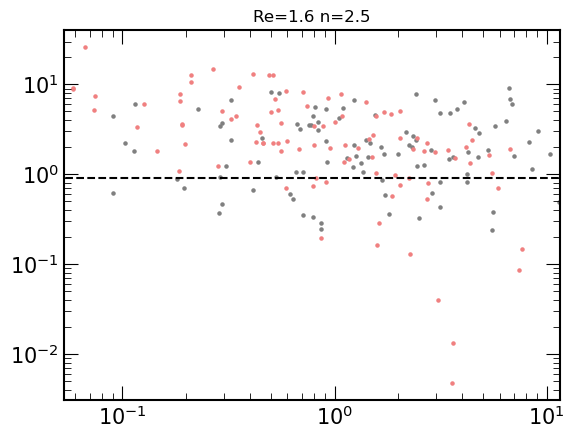

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.304604530334473
2.5 2.1
finished until t = 0.0 0.776766300201416
finished until t = 0.5 5.89223313331604
finished until t = 1.0 14.190438508987427
finished until t = 1.5 27.275202989578247
finished until t = 2.0 44.22928786277771
finished until t = 2.5 65.98866415023804
finished until t = 3.0 91.7780966758728
finished until t = 3.5 121.97318077087402
finished until t = 4.0 156.6306664943695
finished until t = 4.5 196.00785565376282
finished until t = 5.0 239.50837016105652
finished until t = 5.5 286.9805328845978
finished until t = 6.0 338.9119174480438
finished until t = 6.5 395.10992217063904
finished until t = 7.0 456.197820186615
finished until t = 7.5 522.1883008480072
finished until t = 8.0 592.9179496765137
finished until t = 8.5 668.4983818531036
finished until t = 9.0 747.8243741989136
finished until t = 9.5 831.9902551174164
finished until t = 10.0 920.4978950023651


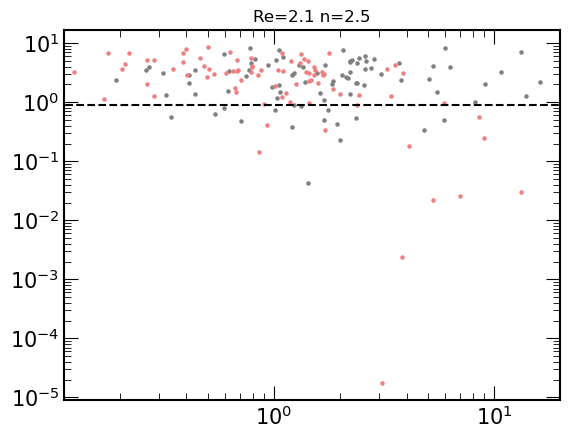

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.941290855407715
2.5 2.6
finished until t = 0.0 0.8684313297271729
finished until t = 0.5 6.865666151046753
finished until t = 1.0 17.698424100875854
finished until t = 1.5 33.27757740020752
finished until t = 2.0 54.196492433547974
finished until t = 2.5 79.90734815597534
finished until t = 3.0 110.70592856407166
finished until t = 3.5 146.21598315238953
finished until t = 4.0 186.7594518661499
finished until t = 4.5 232.17478132247925
finished until t = 5.0 282.479305267334
finished until t = 5.5 338.1960868835449
finished until t = 6.0 400.0962255001068
finished until t = 6.5 466.1108949184418
finished until t = 7.0 536.9583947658539
finished until t = 7.5 612.7884860038757
finished until t = 8.0 693.5001528263092
finished until t = 8.5 779.0899395942688
finished until t = 9.0 870.0620572566986
finished until t = 9.5 965.373307466507
finished until t = 10.0 1066.712777853012


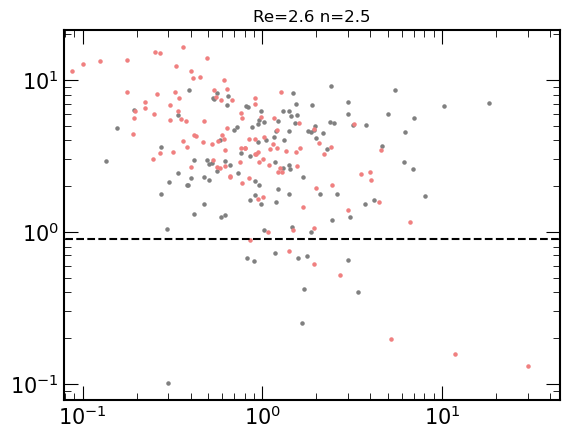

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.284683227539062
2.5 3.1
finished until t = 0.0 0.7919836044311523
finished until t = 0.5 5.486425876617432
finished until t = 1.0 13.997382164001465
finished until t = 1.5 26.477006912231445
finished until t = 2.0 42.60967779159546
finished until t = 2.5 62.707338094711304
finished until t = 3.0 86.86199450492859
finished until t = 3.5 114.1117537021637
finished until t = 4.0 145.47334456443787
finished until t = 4.5 180.18119168281555
finished until t = 5.0 218.97626209259033
finished until t = 5.5 261.614777803421
finished until t = 6.0 307.7767608165741
finished until t = 6.5 357.7796082496643
finished until t = 7.0 412.1959195137024
finished until t = 7.5 470.415513753891
finished until t = 8.0 533.0901935100555
finished until t = 8.5 600.1185829639435
finished until t = 9.0 670.6724689006805
finished until t = 9.5 745.6154277324677
finished until t = 10.0 825.1858515739441


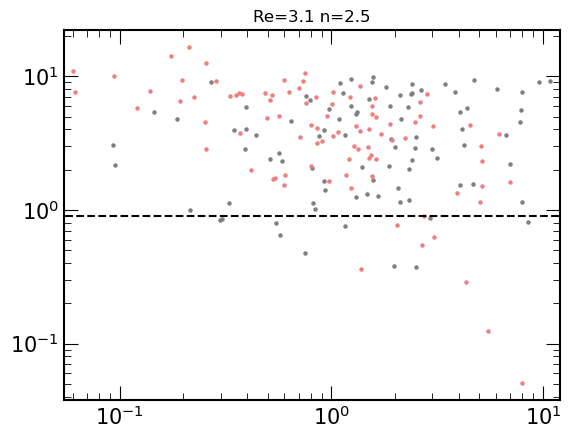

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.797341585159302
2.5 3.6
finished until t = 0.0 0.8182640075683594
finished until t = 0.5 6.198361873626709
finished until t = 1.0 16.630102396011353
finished until t = 1.5 31.41802954673767
finished until t = 2.0 51.04160928726196
finished until t = 2.5 75.7273325920105
finished until t = 3.0 105.00098252296448
finished until t = 3.5 138.82483625411987
finished until t = 4.0 178.24084782600403
finished until t = 4.5 222.29508066177368
finished until t = 5.0 270.5447256565094
finished until t = 5.5 324.02922320365906
finished until t = 6.0 382.93188071250916
finished until t = 6.5 447.0300133228302
finished until t = 7.0 516.7385663986206
finished until t = 7.5 588.900276184082
finished until t = 8.0 661.9210319519043
finished until t = 8.5 739.5483658313751
finished until t = 9.0 822.3405208587646
finished until t = 9.5 909.6931557655334
finished until t = 10.0 1002.1426811218262


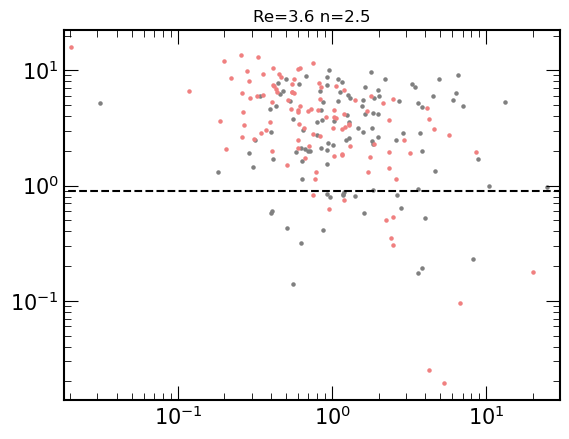

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.341041803359985
2.5 4.1
finished until t = 0.0 0.7910029888153076
finished until t = 0.5 6.406306028366089
finished until t = 1.0 16.261082649230957
finished until t = 1.5 30.864992141723633
finished until t = 2.0 50.1047203540802
finished until t = 2.5 73.60962247848511
finished until t = 3.0 102.47687864303589
finished until t = 3.5 135.7956826686859
finished until t = 4.0 173.09057879447937
finished until t = 4.5 214.98065781593323
finished until t = 5.0 261.8039312362671
finished until t = 5.5 313.4999921321869
finished until t = 6.0 370.16510558128357
finished until t = 6.5 432.36047649383545
finished until t = 7.0 497.4858968257904
finished until t = 7.5 562.6544506549835
finished until t = 8.0 632.9184846878052
finished until t = 8.5 707.5636870861053
finished until t = 9.0 786.4583356380463
finished until t = 9.5 869.4794638156891
finished until t = 10.0 957.3014414310455


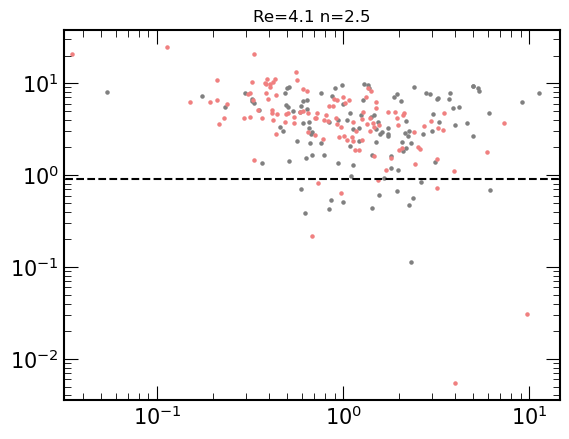

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.269013166427612
2.5 4.6
finished until t = 0.0 0.7359559535980225
finished until t = 0.5 5.169994354248047
finished until t = 1.0 13.468236684799194
finished until t = 1.5 25.388912677764893
finished until t = 2.0 41.15952682495117
finished until t = 2.5 60.53197264671326
finished until t = 3.0 83.66951775550842
finished until t = 3.5 110.29709506034851
finished until t = 4.0 140.59452319145203
finished until t = 4.5 174.59710240364075
finished until t = 5.0 212.4536623954773
finished until t = 5.5 253.94311356544495
finished until t = 6.0 299.16899037361145
finished until t = 6.5 348.3808991909027
finished until t = 7.0 401.0723421573639
finished until t = 7.5 451.4143934249878
finished until t = 8.0 504.2620232105255
finished until t = 8.5 560.441736459732
finished until t = 9.0 620.3653073310852
finished until t = 9.5 683.5800807476044
finished until t = 10.0 750.1383843421936


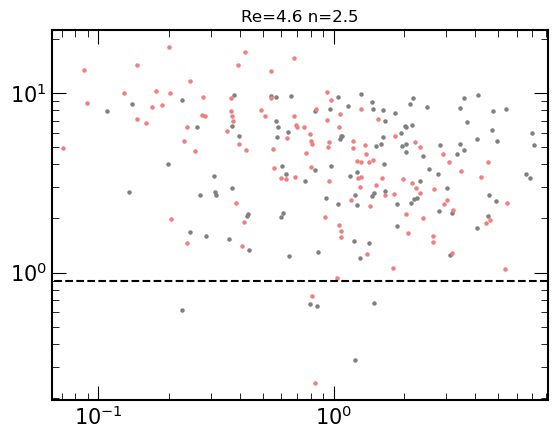

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.329231023788452
2.5 5.1
finished until t = 0.0 0.5336689949035645
finished until t = 0.5 3.7956011295318604
finished until t = 1.0 9.627458095550537
finished until t = 1.5 18.297708749771118
finished until t = 2.0 29.677427053451538
finished until t = 2.5 43.69817805290222
finished until t = 3.0 60.52033257484436
finished until t = 3.5 79.94998240470886
finished until t = 4.0 102.33958959579468
finished until t = 4.5 127.28530311584473
finished until t = 5.0 154.74996709823608
finished until t = 5.5 184.97565698623657
finished until t = 6.0 217.8180992603302
finished until t = 6.5 253.22784996032715
finished until t = 7.0 291.5084037780762
finished until t = 7.5 333.5103278160095
finished until t = 8.0 378.0229694843292
finished until t = 8.5 424.24903631210327
finished until t = 9.0 468.609148979187
finished until t = 9.5 515.507574558258
finished until t = 10.0 564.8304622173309


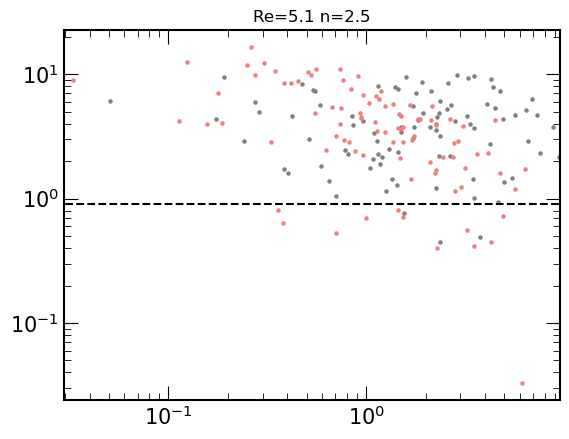

In [3]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [2.5]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [3]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.975620031356812
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
9.395738363265991


In [4]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [2.5]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [5]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 1.8376011848449707
finished until t = 0.5 68.29818224906921
finished until t = 1.0 222.43632650375366
finished until t = 1.5 517.8576266765594
finished until t = 2.0 904.657304763794
finished until t = 2.5 1386.4462566375732
finished until t = 3.0 1961.5148351192474
finished until t = 3.5 2631.6145639419556
finished until t = 4.0 3395.2556915283203
finished until t = 4.5 4252.127593278885
finished until t = 5.0 5204.340342760086
finished until t = 5.5 6250.422564029694
finished until t = 6.0 7378.9274661540985
finished until t = 6.5 8591.235288381577
finished until t = 7.0 9900.047698497772
finished until t = 7.5 11299.846048116684
finished until t = 8.0 12786.522429943085
finished until t = 8.5 14365.758788108826
finished until t = 9.0 16036.429728507996
finished until t = 9.5 17700.55933880806
finished until t = 10.0 19324.897610902786


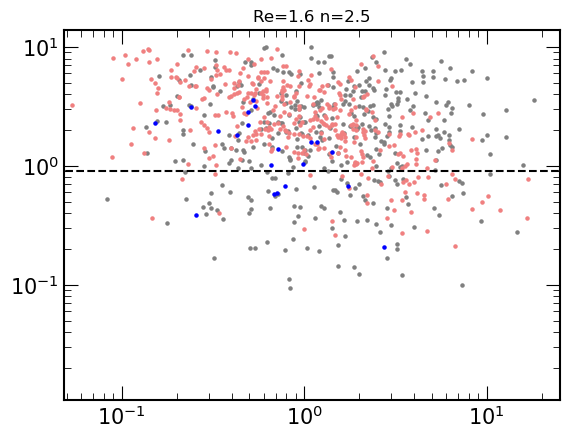

finished until t = 0.0 1.7652339935302734
finished until t = 0.5 77.87843799591064
finished until t = 1.0 227.67286348342896
finished until t = 1.5 449.8213860988617
finished until t = 2.0 744.3934698104858
finished until t = 2.5 1109.3210196495056
finished until t = 3.0 1545.7941446304321
finished until t = 3.5 2052.463551044464
finished until t = 4.0 2629.6206879615784
finished until t = 4.5 3278.6755764484406
finished until t = 5.0 3995.5219011306763
finished until t = 5.5 4782.213152647018
finished until t = 6.0 5635.869976758957
finished until t = 6.5 6557.691930294037
finished until t = 7.0 7548.828577280045
finished until t = 7.5 8607.413985013962
finished until t = 8.0 9733.017230987549
finished until t = 8.5 10929.115744113922
finished until t = 9.0 12190.67595243454
finished until t = 9.5 13279.24585223198
finished until t = 10.0 14309.0765542984


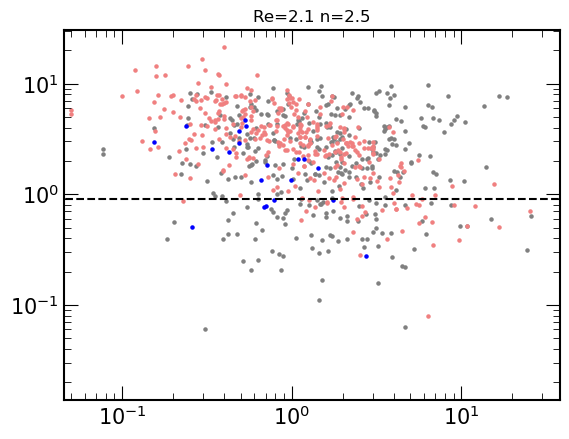

In [6]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 1.8661696910858154


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 20.732683897018433
finished until t = 1.0 52.75469088554382
finished until t = 1.5 98.13358950614929
finished until t = 2.0 157.607839345932
finished until t = 2.5 234.65509796142578
finished until t = 3.0 336.2100794315338
finished until t = 3.5 453.78176498413086
finished until t = 4.0 594.0536270141602
finished until t = 4.5 766.7459194660187
finished until t = 5.0 956.1723780632019
finished until t = 5.5 1159.3614296913147
finished until t = 6.0 1374.486713886261
finished until t = 6.5 1603.5113563537598
finished until t = 7.0 1846.1802055835724
finished until t = 7.5 2101.2867991924286
finished until t = 8.0 2367.391052007675
finished until t = 8.5 2644.665364265442
finished until t = 9.0 2932.9901332855225
finished until t = 9.5 3234.9914996623993
finished until t = 10.0 3526.2892842292786


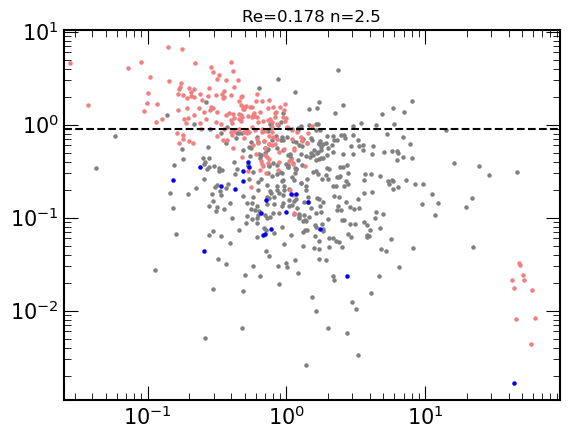

finished until t = 0.0 2.008911609649658
finished until t = 0.5 28.570215463638306
finished until t = 1.0 77.5741229057312
finished until t = 1.5 146.21847796440125
finished until t = 2.0 233.1923954486847
finished until t = 2.5 338.07742643356323
finished until t = 3.0 459.01513719558716
finished until t = 3.5 595.4042594432831
finished until t = 4.0 746.717851638794
finished until t = 4.5 912.5144467353821
finished until t = 5.0 1093.1120641231537
finished until t = 5.5 1289.4032588005066
finished until t = 6.0 1488.9755506515503
finished until t = 6.5 1689.898310661316
finished until t = 7.0 1893.8080251216888
finished until t = 7.5 2070.0801055431366
finished until t = 8.0 2251.153528213501
finished until t = 8.5 2433.312260866165
finished until t = 9.0 2623.2207000255585
finished until t = 9.5 2818.125896692276
finished until t = 10.0 3020.822390794754


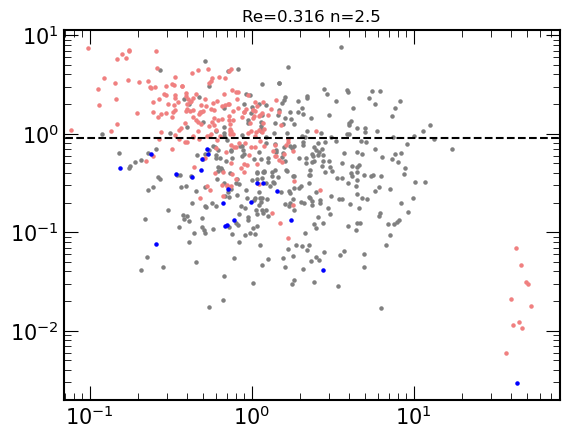

In [7]:
#NFW

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        


        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
